In [1]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

import torch
import json
import matplotlib.pyplot as plt
import numpy as np
from utils import dataprep_utils
import pickle
import copy

In [2]:
# print the current path
!pwd
# change the current path
%cd ..

/home/laurin/Documents/OCTA_project/repo/OCTA_gnn/notebooks


/home/laurin/Documents/OCTA_project/repo/OCTA_gnn


/home/laurin/Documents/OCTA_project/repo/OCTA_gnn/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:

with open("training_configs/feature_name_dict_new.json", "r") as file:
    label_dict_full = json.load(file)
    #features_label_dict = json.load(file)
features_label_dict = copy.deepcopy(label_dict_full)

mode_cv = "cv"
mode_final_test = "final_test"
data_type = "DCP"
split = 1

cv_pickle_processed = f"../data/{data_type}_{mode_cv}_selected_sweep_repeat_v2.pkl"
final_test_pickle_processed = f"../data/{data_type}_{mode_final_test}_selected_sweep_repeat_v2.pkl" 

with open(cv_pickle_processed, "rb") as file:
    cv_dataset = pickle.load(file)
with open(final_test_pickle_processed, "rb") as file:
    final_test_dataset = pickle.load(file)

train_dataset, val_dataset, test_dataset = dataprep_utils.adjust_data_for_split(cv_dataset, final_test_dataset, split, faz = True)

# add the new features to the feature label dict
features_label_dict["graph_1"] = features_label_dict["graph_1"][:-1] + ["cl_mean", "cl_std", "q25", "q75"] #+ ["degree"] #["int_mean", "int_max", "int_min", "std"]
features_label_dict["graph_2"] = features_label_dict["graph_2"][:-1] + ["q25", "q75", "std"] #+ ["degree"] 
features_label_dict["faz"] = features_label_dict["faz"] # + ["q25", "q75", "std"]

features_label_dict_proc = copy.deepcopy(features_label_dict)
features_label_dict_proc["graph_1"] = features_label_dict_proc["graph_1"][:-1] + ["degree"] 
features_label_dict_proc["graph_2"] = features_label_dict_proc["graph_2"][:-1] + ["degree"] 


train dataset: 842
val dataset: 211
test dataset: 211


In [7]:
work_set_proc = train_dataset.hetero_graph_list + val_dataset.hetero_graph_list + test_dataset.hetero_graph_list
work_set = cv_dataset.hetero_graph_list + final_test_dataset.hetero_graph_list 

In [46]:
def distributional_plots(work_set, feature_dict, feature, graph_key, aggregation_mode = "mean", ax = None, color = None):
    """
    This function creates a violinplot of the feature for every disease class
    """

    # extract the correct index for the feature
    idx = feature_dict[graph_key].index(feature)
    agg_features_dict = {}
    for graph in work_set:
        if aggregation_mode == "mean":
            val = torch.mean(graph.x_dict[graph_key][:,idx])
        elif aggregation_mode == "sum":
            val = torch.sum(graph.x_dict[graph_key][:,idx])
        elif aggregation_mode == "std":
            val = torch.std(graph.x_dict[graph_key][:,idx])
        elif aggregation_mode == "max":
            val, _ = torch.max(graph.x_dict[graph_key][:,idx], dim = 0)

        if graph.y.item() in agg_features_dict:
            agg_features_dict[graph.y.item()].append(val.item())
        else:
            agg_features_dict[graph.y.item()] = [val.item()]

    boxplot = []
    for key in agg_features_dict:
        boxplot.append(agg_features_dict[key])
    
    if ax is None:
        fig, ax = plt.subplots()
    violin_parts = ax.violinplot(boxplot, showmedians = True, showextrema=False) #, quantiles=[[0.25, 0.75],[0.25, 0.75],[0.25, 0.75]] 
    ax.set_xlabel("Disease Class")
    #ax.set_ylabel("Avg. " + feature)
    #ax.set_title(f"{aggregation_mode} {feature}")

    if color is not None:
        for pc in violin_parts['bodies']:
            pc.set_facecolor(color)
            pc.set_edgecolor(color)
            pc.set_alpha(0.5)   

    violin_parts["cmedians"].set_color("black")

    # replace the xticks with the correct disease names
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(["Healthy", "NPDR", "PDR"])

    return ax


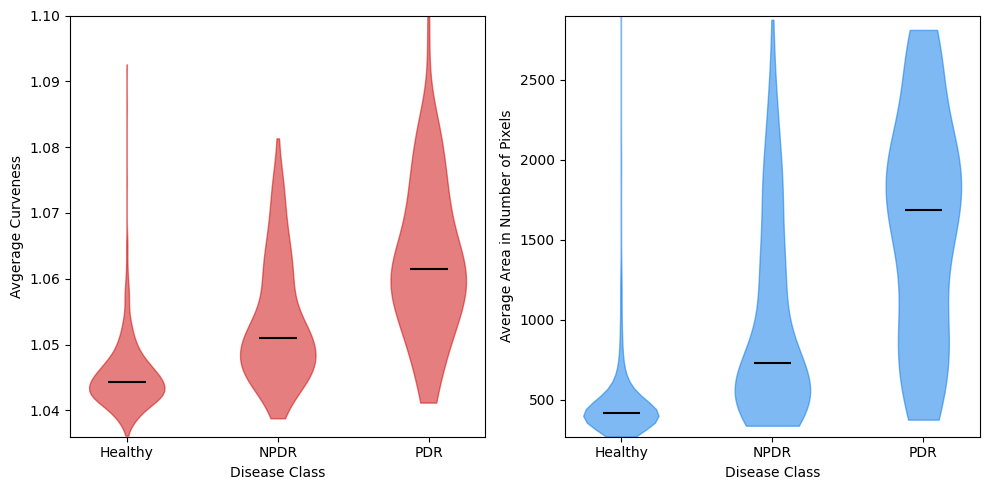

In [51]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
distributional_plots(work_set, features_label_dict, "curveness", "graph_1", "mean", ax[0], color="#CC0000")
distributional_plots(work_set, features_label_dict, "area", "graph_2", "mean", ax[1], color = "#0075E8")
# save the figure as svg and png
ax[0].set_ylim(1.036, 1.10)
ax[1].set_ylim(270, 2900)

ax[0].set_ylabel("Avgerage Curveness")
ax[1].set_ylabel("Average Area in Number of Pixels")
plt.tight_layout()
plt.savefig("pdr_violin.svg")
plt.show()

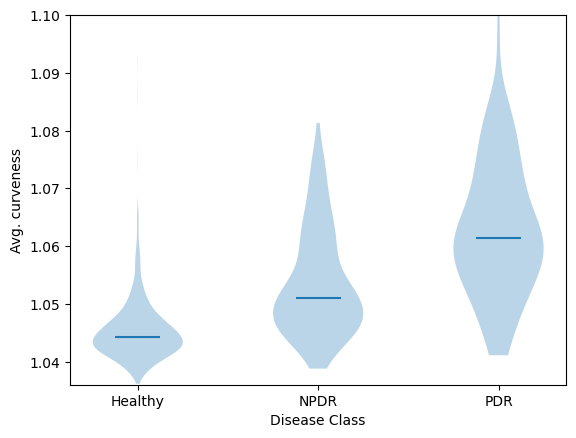

In [33]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
distributional_plots(work_set, features_label_dict, "curveness", "graph_1", "mean", ax[0])
distributional_plots(work_set, features_label_dict, "area", "graph_2", "mean", ax[1])
# save the figure as svg and png
plt.ylim(1.036, 1.10)
plt.savefig("curveness_mean_graph1.svg")
plt.savefig("curveness_mean_graph1.png")
plt.show()

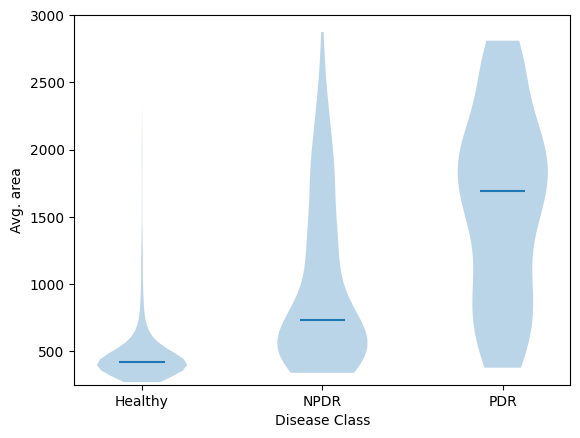

In [34]:
fig, ax = plt.subplots()
distributional_plots(work_set, features_label_dict, "area", "graph_2", "mean", ax)
# save the figure as svg and png
plt.ylim(250, 3000)
plt.savefig("area_mean_graph2.svg")
plt.savefig("area_mean_graph2.png")
plt.show()

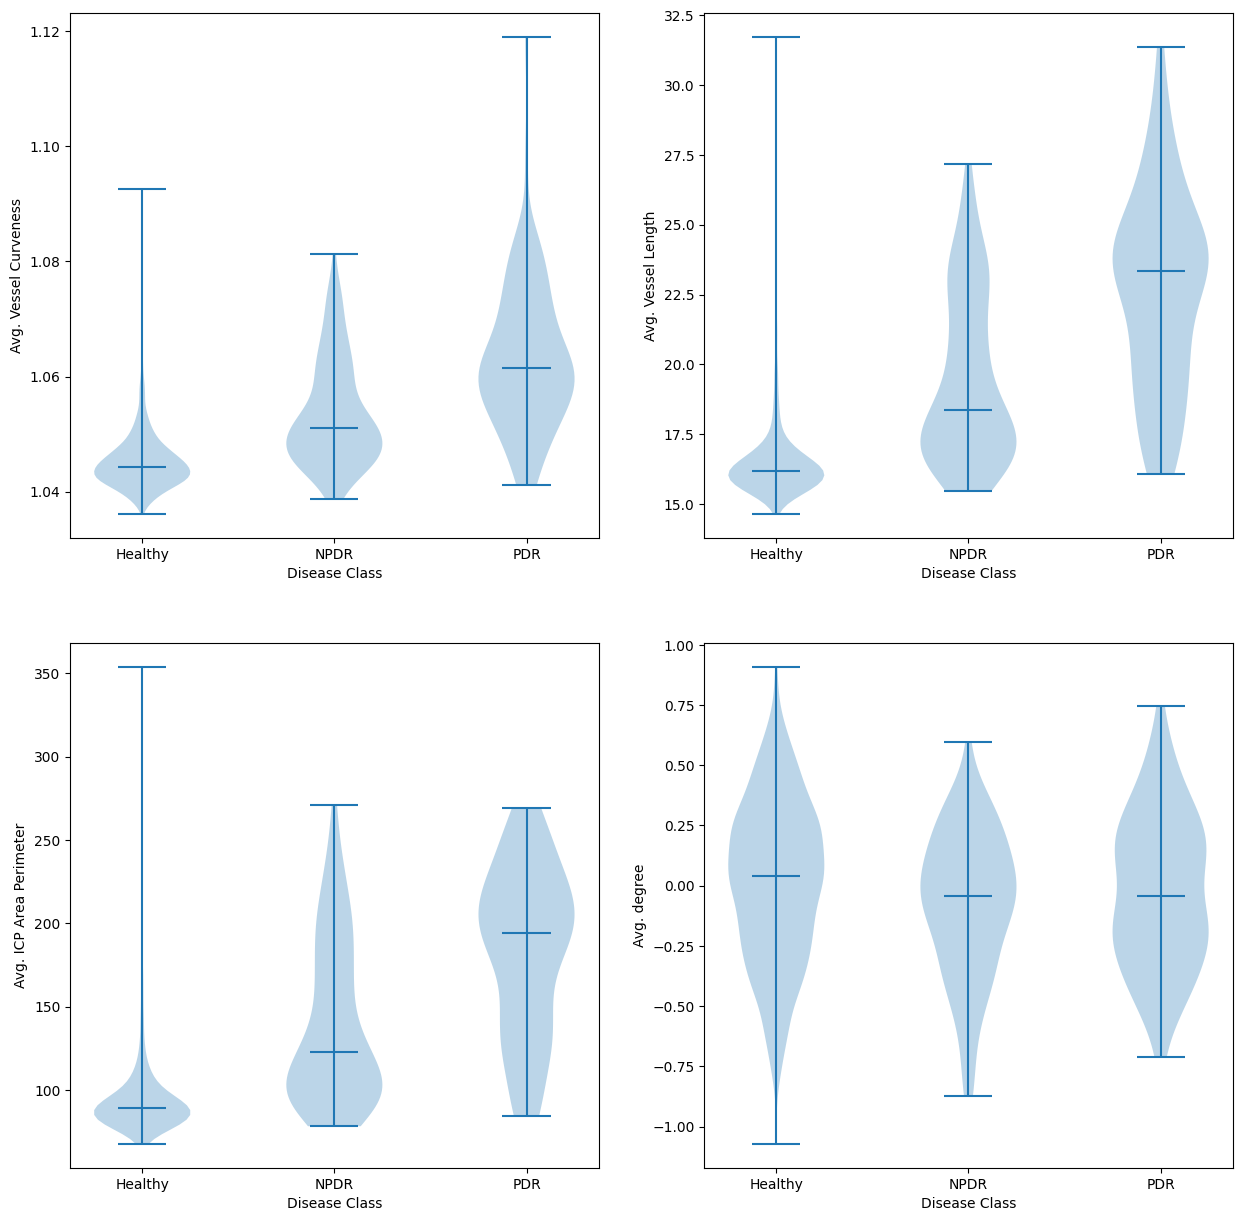

In [13]:
fig, ax = plt.subplots(2, 2, figsize = (15, 15))

ax1 = distributional_plots(work_set, features_label_dict, "curveness", "graph_1", "mean", ax[0,0])
ax1.set_ylabel("Avg. Vessel Curveness")
ax2 = distributional_plots(work_set, features_label_dict, "length", "graph_1", "mean", ax[0,1])
ax2.set_ylabel("Avg. Vessel Length")
ax3 = distributional_plots(work_set, features_label_dict, "perimeter", "graph_2", "mean", ax[1,0])
ax3.set_ylabel("Avg. ICP Area Perimeter")
ax4 = distributional_plots(work_set_proc, features_label_dict_proc, "degree", "graph_2", "mean", ax[1,1])
#ax3.set_ylabel("Avg. ICP Area Minor Axis Length")

plt.show()

In [ ]:
# find the index of feature minRadiusStd
idx_mrs = features_label_dict["graph_1"].index("minRadiusStd")
# count for every graph how often minRadiusStd is zero
zero_sums = []
count_ves = []
labels_y = []
for graph in work_set:
    zero_sums.append(torch.sum(graph.x_dict["graph_1"][:,idx_mrs]==0))
    # append the count of graphs
    count_ves.append(graph.x_dict["graph_1"].shape[1])
    labels_y.append(graph.y.item())


# boxplot of the zero sums according to diseases classes

# create a dictionary with the zero sums and the labels
zero_dict = {}
for i in range(len(labels_y)):
    if labels_y[i] in zero_dict:
        zero_dict[labels_y[i]].append(zero_sums[i].item()/count_ves[i])
    else:
        zero_dict[labels_y[i]] = [zero_sums[i].item()/count_ves[i]]

# create a list of lists for the boxplot
boxplot_data = []
for key in zero_dict:
    boxplot_data.append(zero_dict[key])

# create the boxplot
plt.violinplot(boxplot_data)
plt.xlabel("Disease Class")
plt.ylabel("Number of zero minRadiusStd")
plt.title("Number of zero minRadiusStd for different disease classes")
plt.show()

